<a href="https://colab.research.google.com/github/deepakupman/Word2Vec-SkipGram/blob/master/SkipGram_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word2Vec-SkipGram

**Mount Google Drive to Load data**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


**Reading data from file**

In [0]:
# read in the extracted text file      
with open('/content/gdrive/My Drive/dataset/text8') as f:
    text = f.read()

# print out the first 100 characters
print(text[:100])

 anarchism originated as a term of abuse first used against early working class radicals including t


## Pre-processing

Here I'm fixing up the text to make training easier. The `preprocess` function does a few things:
>* It converts any punctuation into tokens, so a period is changed to ` <PERIOD> `.
* It removes all words that show up five or *fewer* times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. 
* It returns a list of words in the text.

In [0]:
# Replacing special character with terms
from collections import Counter
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    # create counter to remove words that occur less than 5 times
    word_counts = Counter(words)
    return [word for word in words if word_counts[word] > 5]

# creating Lookup table
def create_lookup_table(words):
    words_count = Counter(words)
    # sort the Counter to get frequently occuring words
    sorted_words = sorted(words_count, key=words_count.get, reverse=True)
    
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_words)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}
    return vocab_to_int, int_to_vocab

In [0]:
# get list of words
words = preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [0]:
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 16680599
Unique words: 63641


**Creating two dictionaries to convert words to integers and back again (integers to words)**

In [0]:
vocab_to_int, int_to_vocab = create_lookup_table(words)
int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133, 0, 27349, 1, 0, 102, 854, 2, 0, 15067, 58112, 1, 0, 150, 854, 3580]


## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

$$ P(0) = 1 - \sqrt{\frac{1*10^{-5}}{1*10^6/16*10^6}} = 0.98735 $$

In [0]:
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)
print(list(word_counts.items())[0])  # dictionary of int_words, how many times they appear

total_count = len(int_words)
frequency = {word: ctr/total_count for word, ctr in word_counts.items()}
prob_drop = {word: 1 - np.sqrt(threshold / frequency[word]) for word in word_counts}

# discard some frequent words, according to the subsampling equation
# create a new list of words for training
train_words = [word for word in int_words if random.random() < (1-prob_drop[word])]

print(train_words[:30])

(5233, 303)
[3080, 3133, 45, 127, 741, 10571, 27349, 102, 854, 15067, 58112, 150, 3580, 194, 10712, 1324, 454, 58, 2731, 97, 7088, 1052, 27, 44611, 2877, 792, 5233, 8983, 4147, 6437]


**Generating target**:  With the skip-gram architecture, for each word in the text, we want to define a surrounding context and grab all the words in a window around that word, with size C

**From Mikolov et al.:** 
"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose C=5
, for each training word we will select randomly a number R
 in range [1:C]
, and then use R
 words from history and R
 words from the future of the current word as correct labels."
. 

In [0]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    R = random.randint(1, window_size+1)
    # implement this function
    first = idx-R if (idx-R) > 0 else 0
    last = idx+R if (idx+R) < len(words) else len(words)-1
    wordlist = words[first:idx] + words[idx+1:last+1]
    return wordlist

**Validate correctness of get_target function**

In [0]:
# run this cell multiple times to check for random window selection
int_text = [5233, 58, 741, 10571, 27349, 0, 15067, 58112, 3580, 58, 10712] # [i for i in range(10)]
print('Input: ', int_text)
idx = 2 # word index of interest

target = get_target(int_text, idx=idx, window_size=5)
print('Target: ', target)  # you should get some indices around the idx

Input:  [5233, 58, 741, 10571, 27349, 0, 15067, 58112, 3580, 58, 10712]
Target:  [58, 10571]


**Generating Batches**

Generator function to generate batches of input data and target using get_target function

In [0]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

**Validate get_batches function**

In [0]:
int_text = [i for i in range(20)]
x, y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 0, 1, 1, 2, 2, 2, 3, 3, 3]
y
 [1, 2, 0, 2, 0, 1, 3, 0, 1, 2]


**Cosine Similarity function to validate similarity between the word generated by model**
$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$

In [0]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

In [0]:
import torch
from torch import nn
import torch.optim as optim

**Creating the model for SkipGram**

In [0]:
class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        self.embed = nn.Embedding(n_vocab, n_embed)
        # complete this SkipGram model
        self.fc = nn.Linear(n_embed, n_vocab)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        
        # define the forward behavior
        x = self.embed(x)
        x = self.fc(x)
        x = self.log_softmax(x)
        
        return x

In [0]:
# check if GPU is available
from tqdm import tqdm_notebook
device = 'cuda' if torch.cuda.is_available() else 'cpu'

embedding_dim=300 # you can change, if you want

model = SkipGram(len(vocab_to_int), embedding_dim).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 500
steps = 0
epochs = 5

# train for some number of epochs
for e in range(epochs):
    
    # get input and target batches
    for inputs, targets in tqdm_notebook(get_batches(train_words, 512)):
        steps += 1
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)
        
        log_ps = model(inputs)
        loss = criterion(log_ps, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if steps % print_every == 0:                  
            # getting examples and similarities      
            valid_examples, valid_similarities = cosine_similarity(model.embed, device=device)
            _, closest_idxs = valid_similarities.topk(6) # topk highest similarities
            
            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...")

to | lege, manseriche, recorder, roundheads, agis
six | intron, firm, basically, shermer, supporter
over | audacity, golden, atlas, personage, infringing
may | nizkor, submerged, lazarev, emunah, courageous
only | encampments, gomer, corrigan, broke, mixing
the | buckle, azteca, rifled, riemann, tendon
or | fredric, lemnian, kryptonian, lordships, phillips
so | wba, insights, delegated, analogously, bayonet
existence | khalid, sanity, belushi, rope, unrequited
http | genius, oppressor, worried, clin, blink
pre | translocation, undisturbed, sea, suspended, sedgewick
freedom | bougainville, ct, marvin, overzealous, markings
accepted | gorman, zanu, karloff, breath, canticles
ocean | cormack, klara, vulva, hdl, instytut
bible | permaculture, anthracis, believing, timepiece, iktinos
universe | perhaps, bca, daphne, stephen, hci
...
use | slovakian, hine, vulva, korea, linger
would | fathering, except, feet, reels, humankind
while | hoses, posner, lalo, lipscomb, squirrel
who | munroe, diss

**Plotting the words**

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [0]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.embed.weight.to('cpu').data.numpy()

In [0]:
viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

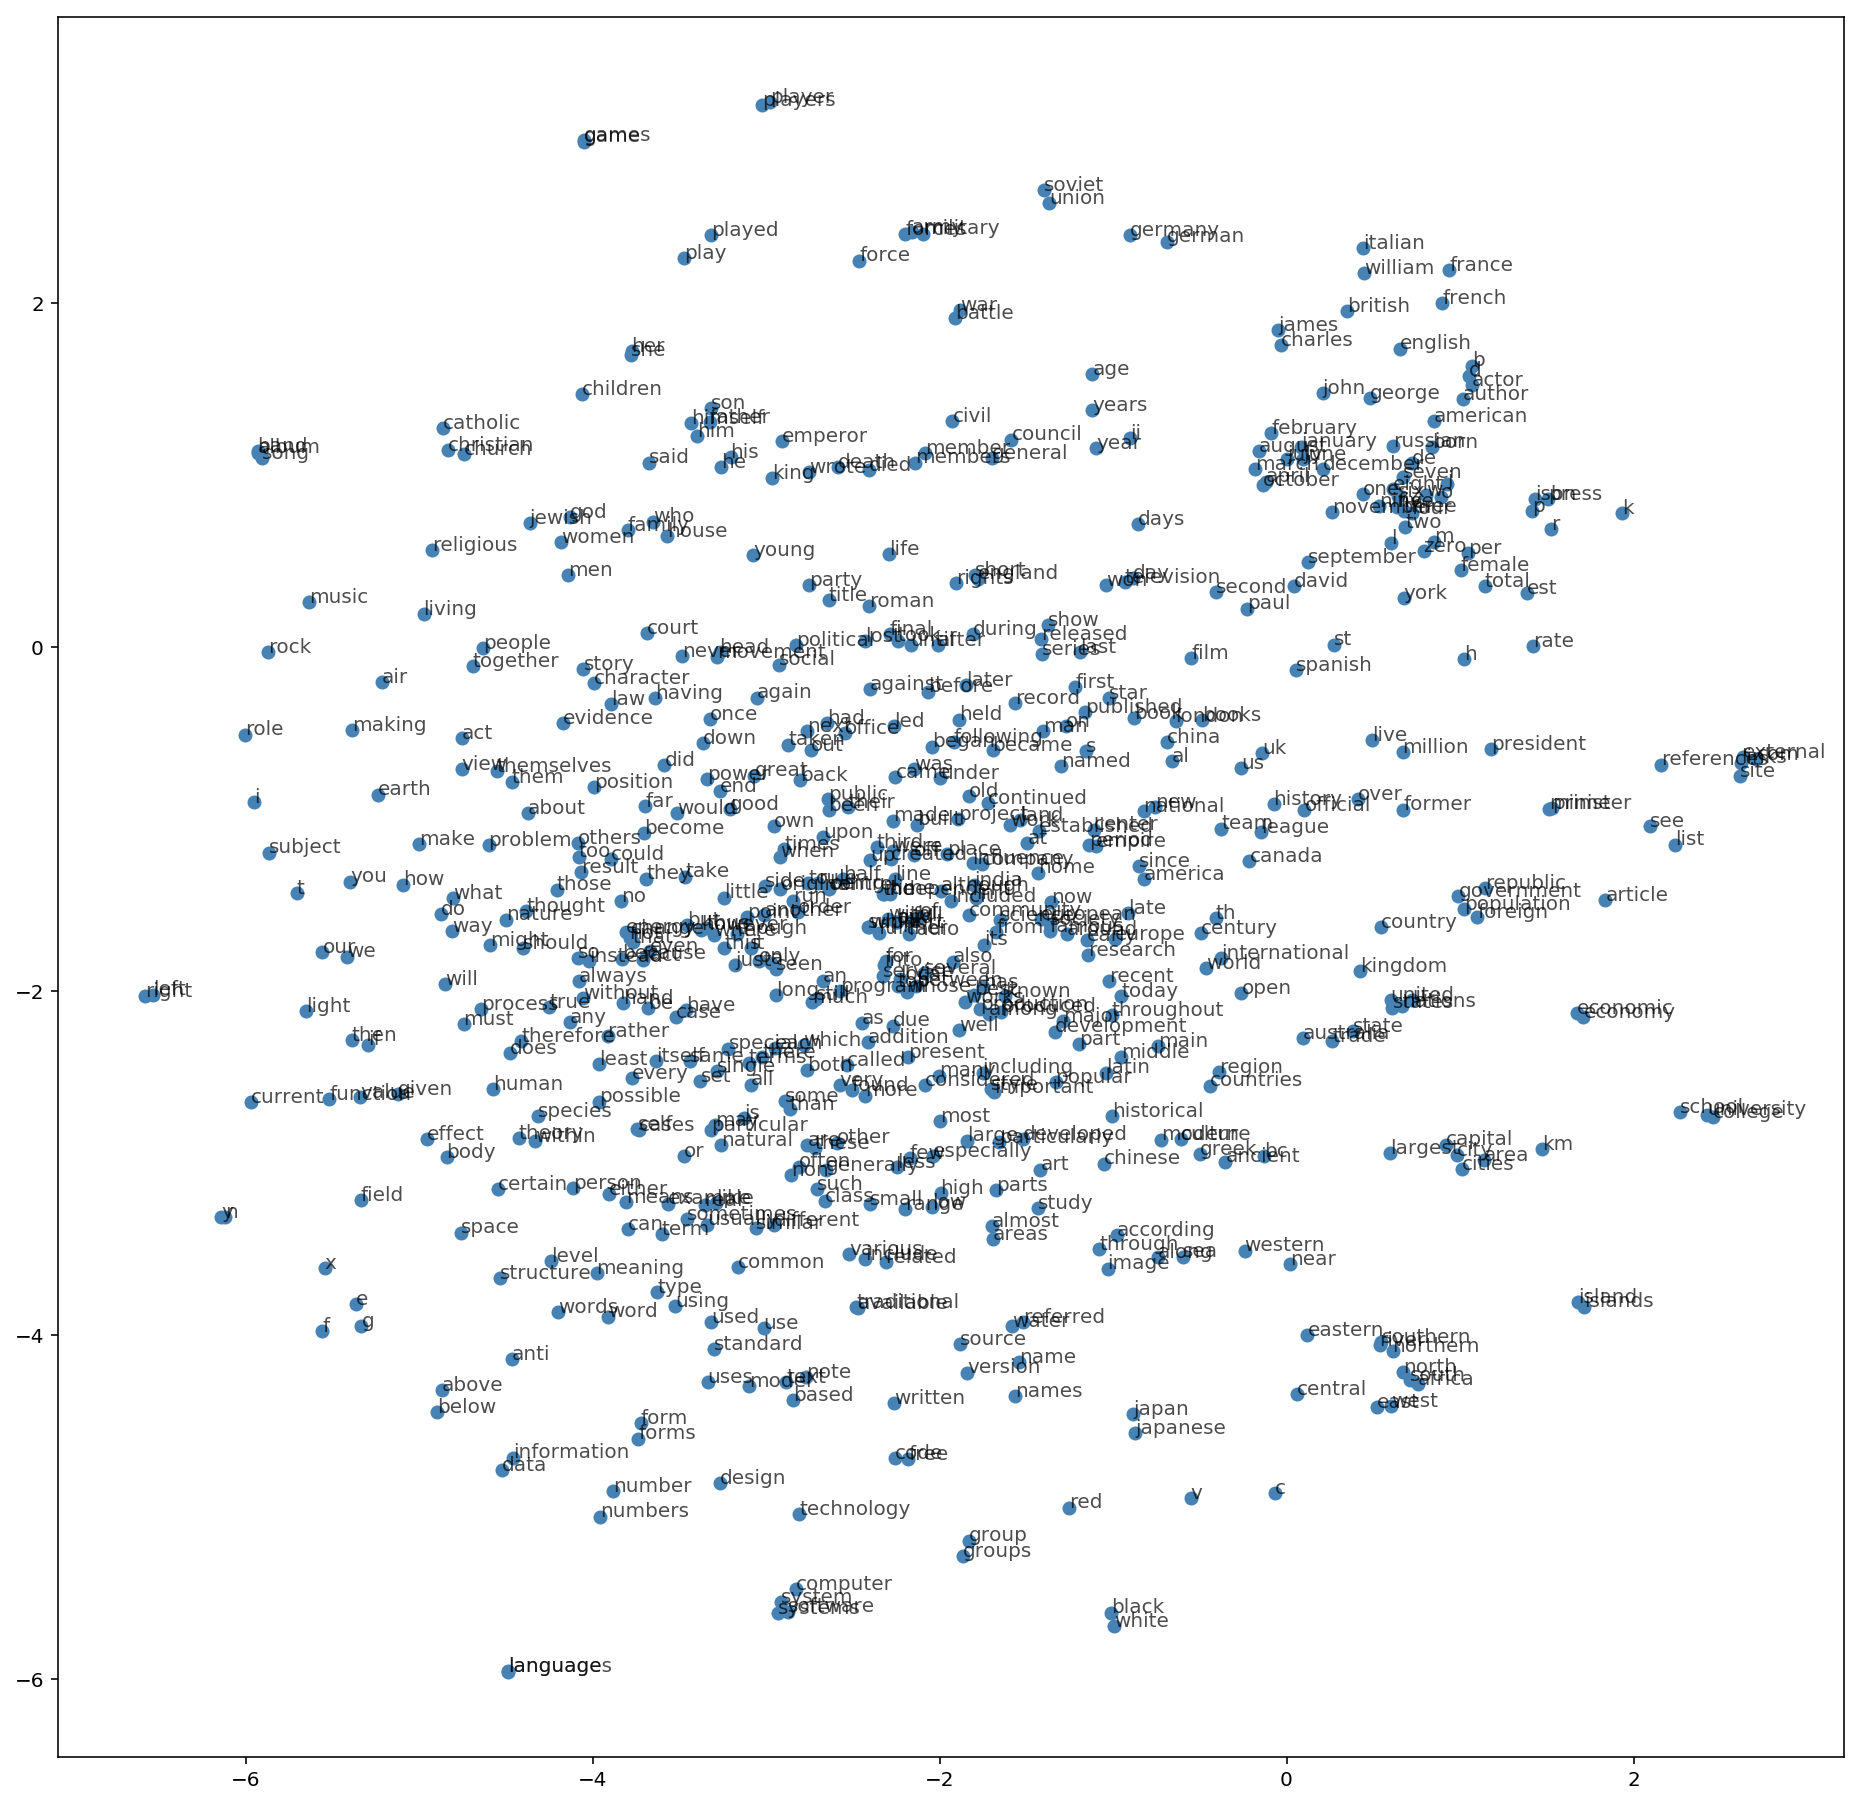

In [0]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)